In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from importlib import reload
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join( os.pardir, os.pardir)))
import stl.stl_optimizer as opt
import stl.stl as stl

import numpy as np
from collections import OrderedDict
import sympy as sym
import copy
import time
from deap import base, creator, tools


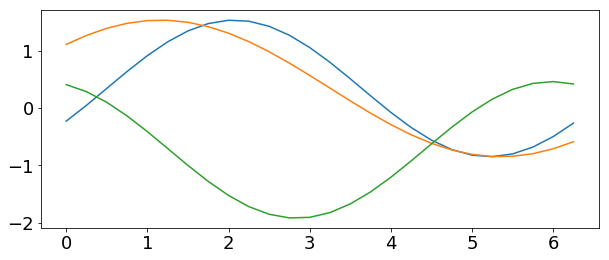

In [166]:
a, b = np.pi*2, 0.25
t = np.arange(0, a, b)
x_values = np.sin(t - 0.5)
y_values = np.sin(0.75*t + 0.7)
z_values = (np.cos(t + 0.3)-0.9)
μ, σ = np.mean(np.concatenate([x_values, y_values, z_values])), np.std(np.concatenate([x_values, y_values, z_values]))
# μ, σ = 0 ,1
x_values = (x_values - μ)/σ
y_values = (y_values - μ)/σ
z_values = (z_values - μ)/σ
xyz_values = [[x, y, z] for (x, y, z) in zip(x_values, y_values, z_values)]
xyz_trace = stl.Trace.from_signals(xyz_values, var_name=[sym.symbols("x"), sym.symbols("y"), sym.symbols("z")])
plt.figure(figsize=(10,4))
plt.plot(t, x_values, label="x")
plt.plot(t, y_values, label="y")
plt.plot(t, z_values, label="z")
matplotlib.rcParams.update({'font.size': 18})
# plt.legend()

In [167]:
α, β, x, y, z = sym.symbols("α β x y z") 
I1 = stl.Interval(2, 5)
# I2 = stl.Interval(0, 5)

In [11]:
α, β, x, y, z = sym.symbols("α β x y z") 
I1 = stl.Interval(2, 5)
formula_1 = stl.And(stl.Always(stl.Comparison("<", x, α)) , stl.Always(stl.Comparison("<", y, β)))
formula_2 = stl.Or(stl.And(stl.Always(stl.Comparison("<", x, α)), stl.Always(stl.Comparison("<", y, β))), 
                   stl.Always(stl.Comparison("<", z, α)))

A = stl.Comparison(">", x, α)
B = stl.Comparison("<", y, β)
AA = stl.And(A, B)
lhs = stl.Eventually(stl.Always(AA, interval=I1))
rhs = stl.Always(stl.Comparison("<", z, α))
formula_3 = stl.And(lhs, rhs)


A = stl.Comparison(">", x, α + β)
B = stl.Comparison("<", y, α**2 - β)
AA = stl.And(A, B)
lhs = stl.Eventually(stl.Always(AA, interval=I1))
rhs = stl.Always(stl.Comparison("<", z, α+2*β**2))
formula_4 = stl.And(lhs, rhs)

def select_formula(n):
    if n == 1: return formula_1
    elif n == 2: return formula_2
    elif n == 3: return formula_3
    elif n == 4: return formula_4
    else: return None
    
    
for i in range(1,5):
    print(select_formula(i))


(◻ [0, inf] (x<α)) ∧ (◻ [0, inf] (y<β))
((◻ [0, inf] (x<α)) ∧ (◻ [0, inf] (y<β))) ∨ (◻ [0, inf] (z<α))
(◇ [0, inf] (◻ [2, 5] ((x>α) ∧ (y<β)))) ∧ (◻ [0, inf] (z<α))
(◇ [0, inf] (◻ [2, 5] ((x>α + β) ∧ (y<α**2 - β)))) ∧ (◻ [0, inf] (z<α + 2*β**2))


In [6]:
def loss_fn(formula, val, tr):
    for (k,v) in val.items():
        formula = formula.subs(k, v)
    return formula.robustness(tr)**2

# Gradient descent

In [64]:
def gradient_descent_trials(n, xyz_trace, N=100, num_steps=1000):
    formula = select_formula(n)
    lr = 0.01
    gd = opt.STLGradientDescent(lr, verbose=True)
    num_iterations = []
    losses = []
    t0 = time.time()
    for run in range(N):
        print("RUN NUM: ", run)
        valuations = OrderedDict({α:2*np.random.rand()-1, β:2*np.random.rand()-1})
        for i in range(num_steps):
            if i % 100 == 0:
                print("num_steps = ", i)
            valuations, grad = gd.step(valuations, formula, loss_fn, xyz_trace)
            loss = loss_fn(formula, valuations, xyz_trace)
            if grad[α]**2 + grad[β]**2 < 1:
                break
        num_iterations.append(i+1)
        losses.append(loss)
    t1 = time.time()
    total = t1-t0

    gd = {"total_time": total, "num_iterations": num_iterations, "losses": losses}
    np.save("gd_"+str(n) + ".npy", gd)
#     np.save("test.npy", gd)


In [65]:
# gradient_descent_trials(4, xyz_trace, 5, 10)

RUN NUM:  0
num_steps =  0
Gradient:   α: -2.2299   β: 0.0763   
:    Valuations:   α: -0.6213   β: -0.0093   

Gradient:   α: -2.1629   β: 0.0806   
:    Valuations:   α: -0.5997   β: -0.0101   

Gradient:   α: -2.0979   β: 0.085   
:    Valuations:   α: -0.5787   β: -0.011   

Gradient:   α: -2.0349   β: 0.0893   
:    Valuations:   α: -0.5583   β: -0.0119   

Gradient:   α: -1.9737   β: 0.0937   
:    Valuations:   α: -0.5386   β: -0.0128   

Gradient:   α: -1.9144   β: 0.0981   
:    Valuations:   α: -0.5194   β: -0.0138   

Gradient:   α: -1.8568   β: 0.1024   
:    Valuations:   α: -0.5009   β: -0.0148   

Gradient:   α: -1.8009   β: 0.1067   
:    Valuations:   α: -0.4829   β: -0.0159   

Gradient:   α: -1.7467   β: 0.1109   
:    Valuations:   α: -0.4654   β: -0.017   

Gradient:   α: -1.6941   β: 0.1151   
:    Valuations:   α: -0.4485   β: -0.0181   

RUN NUM:  1
num_steps =  0
Gradient:   α: 1.5667   β: -2.1766   
:    Valuations:   α: 0.3442   β: -0.9443   

Gradient:   α: 

In [132]:
np.std(np.array([round(x,6) for x in gd['losses']]))

1.4e-07

In [270]:
ga = np.load("ga_4_20_40.npy").item()

In [271]:
ga

{'total_time': 2599.3176889419556,
 'losses': [0.0184218517593456,
  2.12378083395599e-8,
  0.0124242130392463,
  0.00725445886022666,
  0.00122938957119526,
  4.54605124064854e-7,
  0.00846593273172154,
  3.10413087665325e-5,
  0.00159876560145757,
  0.00225411349785452,
  0.0115370801230017,
  0.00117348443850735,
  6.95917815749330e-6,
  0.0144315890394270,
  0.00409459252758385,
  0.0110184695023014,
  0.000626079089809877,
  6.90455157788844e-7,
  1.75624310791580e-5,
  0.00155791428060884,
  0.000131641088378982,
  0.00144877360917488,
  0.00334717496263020,
  6.89878110026140e-5,
  0.00862343089843346,
  0.00537852920607403,
  0.000337086417845921,
  0.000582572443670169,
  0.00417923843507257,
  2.13859438326423e-7,
  0.000985473987794361,
  5.52501988670594e-7,
  0.00982410348668032,
  9.69555651385151e-5,
  0.00167729094091399,
  0.0683997110441745,
  0.000430884952276776,
  0.00900867671024284,
  0.000436036869518695,
  0.00775161516389007,
  0.00845930835781154,
  0.0006000

# Genetic Algorithms

In [11]:
formula = select_formula(1)

In [ ]:
### def genetic_algorithm_trials(n, xyz_trace, N=100, ngen=20, pop_size=40):
    formula = select_formula(n)
    losses = []
    settings = {'select': tools.selection.selTournament,
            'crossover': tools.crossover.cxSimulatedBinary,
            'mutate':tools.mutation.mutPolynomialBounded,
            'ngen': ngen,
            'tournsize': 10,
            'cxpb': 0.5,
            'indpb': 0.01,
            'mutpb': 0.2,
            'eta': 0.5,
            'lb': 0,
            'ub': 10}
    pop_size = pop_size
    ga = opt.STLGeneticAlgorithm(settings, verbose=True)
    var = [α, β]
    t0 = time.time()
    for i in range(N):
        
        pop = ga.create_population(var, pop_size, loss_fn, formula, xyz_trace)
        pop = ga.optimize(settings['ngen'], pop)
        best = ga.select_best(pop)
        loss = loss_fn(formula, {α:best[0][0], β:best[0][1]}, xyz_trace)
        losses.append(loss)
    t1 = time.time()
    total = t1 - t0
    ga = {"total_time": total,"losses": losses}
    np.save("ga_"+str(n) + ".npy", ga) 

In [10]:
genetic_algorithm_trials(1, xyz_trace, N=20, ngen=3, pop_size=3)

/Users/karenleung/miniconda2/envs/trams/lib/python3.6/site-packages/deap-1.2.2-py3.6-macosx-10.9-x86_64.egg/deap/creator.py:141: RuntimeWarning: A class named 'STLFitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/karenleung/miniconda2/envs/trams/lib/python3.6/site-packages/deap-1.2.2-py3.6-macosx-10.9-x86_64.egg/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [116]:
np.load("gd_3.npy").item()['losses']

[0.0523298631874991,
 0.189101796501378,
 9.69063951873584e-7,
 9.90741390010015e-7,
 0.0523252870593177,
 0.189101798799415,
 9.81285826830086e-7,
 9.81042147217443e-7,
 9.62452224974735e-7,
 9.81789974940937e-7,
 0.0523252884470855,
 0.116156440129924,
 0.189093102977917,
 9.87971965111066e-7,
 9.48116970527249e-7,
 9.61686720708815e-7,
 9.83387553699790e-7,
 9.65880318959752e-7,
 9.97792625341318e-7,
 9.45199450185315e-7,
 0.116156440051406,
 9.96182439497252e-7,
 9.62562010177062e-7,
 0.189093102947289,
 0.116156438916902,
 9.91981147918968e-7,
 9.68520324509670e-7,
 9.98852926323123e-7,
 0.0523252872256837,
 9.75839830589065e-7,
 0.255029023315979,
 9.84070816514109e-7,
 9.86264237657892e-7,
 9.64656451596214e-7,
 0.116156442456677,
 9.83515552802080e-7,
 9.47385323543708e-7,
 9.80033910491122e-7,
 9.74533647482546e-7,
 0.0523252886648983,
 0.0111547503492258,
 9.84175361682608e-7,
 0.116163256250781,
 9.42752965956969e-7,
 0.0523298653941382,
 0.0523298618933017,
 0.0523252879212

# Computation graph

In [619]:
import learning
reload(learning)
import learning as ln
import torch

In [620]:
x_tensor = torch.tensor([xyz_trace.series[x][-k-1]  for k in range(len(xyz_trace.series[x]))], dtype=torch.float64).unsqueeze(0)
y_tensor = torch.tensor([xyz_trace.series[y][-k-1]  for k in range(len(xyz_trace.series[y]))], dtype=torch.float64).unsqueeze(0)
z_tensor = torch.tensor([xyz_trace.series[z][-k-1]  for k in range(len(xyz_trace.series[z]))], dtype=torch.float64).unsqueeze(0)

In [621]:
gradient_tol = 1E-10
loss_tol = 1E-6

In [622]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

# scaling
# def scaling_schedule(i, NUM_EPOCH):
#     return float(100*sigmoid((i - 3*NUM_EPOCH/10)/150))

# scaling_1
def scaling_schedule(i, NUM_EPOCH):
    return float(100*sigmoid((i - 2*NUM_EPOCH/10)/50))

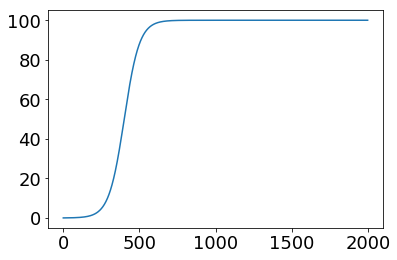

In [623]:
NUM_EPOCH = 2000
plt.plot([scaling_schedule(i, NUM_EPOCH) for i in range(NUM_EPOCH)])

In [624]:
def run_formula_1(N, scaling=True, verbose=True):
    NUM_EPOCH = N
    learning_rate = 0.01
    α = torch.randn(1,  dtype=torch.float64, requires_grad=True)
    β = torch.randn(1,  dtype=torch.float64, requires_grad=True)
    A = ln.LessThan("x", α)
    B = ln.LessThan("y", β)
    lhs = ln.STLModel(A, ln.Always())
    rhs = ln.STLModel(B, ln.Always())
    optim = torch.optim.Adam([α,β], lr=learning_rate)
    for epoch in range(NUM_EPOCH):            
        # ------------------------------------------ exact loss -------------------------------------------------------- #
        scale = -1
        x_setup = lhs.setup(x_tensor, scale=scale)
        lhs_outputs, _ = lhs.outer.run_cell(x_setup, lhs.outer.initialize_rnn_cell(x_setup), scale=scale)
        lhs_output = lhs(x_tensor, scale=scale)
        y_setup = rhs.setup(y_tensor, scale=scale)
        rhs_outputs, _ = rhs.outer.run_cell(y_setup, rhs.outer.initialize_rnn_cell(y_setup), scale=scale)
        rhs_output = rhs(x_tensor, scale=scale)
        formula_1 = ln.And(ln.GreaterThan("lhs", 0), ln.GreaterThan("rhs", 0))
        exact_loss = formula_1(lhs_output, rhs_output, scale=scale)**2
        # -------------------------------------------------------------------------------------------------------- #
        if exact_loss <= loss_tol:
            print("EXACT LOSS IS SMALL ENOUGH")
            break
            
        if scaling:
            scale = scaling_schedule(epoch, NUM_EPOCH)

        # ------------------------------------------ LOSS -------------------------------------------------------- #
            x_setup = lhs.setup(x_tensor, scale=scale)
            lhs_outputs, _ = lhs.outer.run_cell(x_setup, lhs.outer.initialize_rnn_cell(x_setup), scale=scale)
            lhs_output = lhs(x_tensor, scale=scale)
            y_setup = rhs.setup(y_tensor, scale=scale)
            rhs_outputs, _ = rhs.outer.run_cell(y_setup, rhs.outer.initialize_rnn_cell(y_setup), scale=scale)
            rhs_output = rhs(x_tensor, scale=scale)
            formula_1 = ln.And(ln.GreaterThan("lhs", 0), ln.GreaterThan("rhs", 0))
            loss = formula_1(lhs_output, rhs_output, scale=scale)**2
        # -------------------------------------------------------------------------------------------------------- #
        else:
            loss = exact_loss

        loss.backward()
        with torch.no_grad():
            if epoch % 100 == 0:
                if verbose:
                    print("Epoch: ", epoch,
                          "\t β is : ", round(β.cpu().data.numpy()[0],3),
                          "\t α is : ", round(α.cpu().data.numpy()[0],3),
                          "\t Gradient: ", round(β.grad.data.numpy()[0]**2 + α.grad.data.numpy()[0]**2, 7),
                          "\t Loss: ", round(float(loss.data.numpy()), 3),
                          "\t Exact Loss: ", round(float(exact_loss.data.numpy()), 3),
                          "\t Scale: ", round(scale, 3))
#             β -= learning_rate * (β.grad + 0.001*torch.randn(1,  dtype=torch.float64))
#             α -= learning_rate * (α.grad + 0.001*torch.randn(1,  dtype=torch.float64))
            optim.step()
            if α.grad**2 + β.grad**2  < gradient_tol:
                print("Gradient IS SMALL ENOUGH")
                break
            β.grad.zero_()
            α.grad.zero_()
    return exact_loss, epoch

In [625]:
def run_formula_2(N, scaling=True, verbose=True):
    NUM_EPOCH = N
    learning_rate = 0.01
    α = torch.randn(1,  dtype=torch.float64, requires_grad=True)
    β = torch.randn(1,  dtype=torch.float64, requires_grad=True)
    A = ln.LessThan("x", α)
    B = ln.LessThan("y", β)
    C = ln.GreaterThan("z", α)
    lhs = ln.STLModel(A, ln.Always())
    rhs = ln.STLModel(B, ln.Always())
    LHS = ln.And(ln.GreaterThan(str(lhs), 0), ln.GreaterThan(str(rhs), 0))
    RHS = ln.STLModel(C, ln.Always())
    optim = torch.optim.Adam([α,β], lr=learning_rate)
    for epoch in range(NUM_EPOCH):
        # ------------------------------------------ exact loss -------------------------------------------------------- #
        scale = -1
        x_setup = lhs.setup(x_tensor, scale=scale)
        lhs_outputs, _ = lhs.outer.run_cell(x_setup, lhs.outer.initialize_rnn_cell(x_setup), scale=scale)
        lhs_output = lhs(x_tensor, scale=scale)
        y_setup = rhs.setup(y_tensor, scale=scale)
        rhs_outputs, _ = rhs.outer.run_cell(y_setup, rhs.outer.initialize_rnn_cell(y_setup), scale=scale)
        rhs_output = rhs(x_tensor, scale=scale)
        RHS_output = RHS(z_tensor, scale=scale)
        formula_2 = ln.Or(ln.GreaterThan(str(LHS), 0), ln.GreaterThan(str(RHS), 0))
        exact_loss = formula_2(LHS(lhs_output, rhs_output, scale=scale), RHS_output, scale=scale)**2
        
        # -------------------------------------------------------------------------------------------------------- #
        if exact_loss <= loss_tol:
            print("EXACT LOSS IS SMALL ENOUGH")
            break
            
        if scaling:
            scale = scaling_schedule(epoch, NUM_EPOCH)
        
        # ------------------------------------------ LOSS -------------------------------------------------------- #
            x_setup = lhs.setup(x_tensor, scale=scale)
            lhs_outputs, _ = lhs.outer.run_cell(x_setup, lhs.outer.initialize_rnn_cell(x_setup), scale=scale)
            lhs_output = lhs(x_tensor, scale=scale)
            y_setup = rhs.setup(y_tensor, scale=scale)
            rhs_outputs, _ = rhs.outer.run_cell(y_setup, rhs.outer.initialize_rnn_cell(y_setup), scale=scale)
            rhs_output = rhs(x_tensor, scale=scale)
            RHS_output = RHS(z_tensor, scale=scale)
            formula_2 = ln.Or(ln.GreaterThan(str(LHS), 0), ln.GreaterThan(str(RHS), 0))
            loss = formula_2(LHS(lhs_output, rhs_output, scale=scale), RHS_output, scale=scale)**2
        else:
            loss = exact_loss
        # -------------------------------------------------------------------------------------------------------- #

        loss.backward()
        with torch.no_grad():
            if epoch % 100 == 0:
                if verbose:
                    print("Epoch number: ", epoch,
                          "\t β is : ", round(β.cpu().data.numpy()[0],3),
                          "\t α is : ", round(α.cpu().data.numpy()[0],3),
                          "\t Gradient is: ", round(β.grad.data.numpy()[0]**2 + α.grad.data.numpy()[0]**2, 7),
                          "\t Loss is: ", round(float(loss.data.numpy()), 3),
                          "\t Exact Loss is: ", round(float(exact_loss.data.numpy()), 3),
                          "\t Scale is: ", round(scale, 3))
#             β -= learning_rate * (β.grad + 0.001*torch.randn(1,  dtype=torch.float64))
#             α -= learning_rate * (α.grad + 0.001*torch.randn(1,  dtype=torch.float64))
            optim.step()
            if α.grad**2 + β.grad**2  < gradient_tol:
                print("Gradient IS SMALL ENOUGH")
                break
            β.grad.zero_()
            α.grad.zero_()
    return exact_loss, epoch



In [626]:
def run_formula_3(N, scaling=True, verbose=True):
    NUM_EPOCH = N
    learning_rate = 0.01
    α = torch.randn(1,  dtype=torch.float64, requires_grad=True)
    β = torch.randn(1,  dtype=torch.float64, requires_grad=True)
    A = ln.GreaterThan("x", α)
    B = ln.LessThan("y", β)
    AA = ln.And(A, B)
    temp_inner = ln.Always(I1)
    temp_outer = ln.Eventually()
    temp = ln.TemporalComposition(temp_inner, temp_outer)
    lhs = ln.STLModel(AA, temp)
    inner = ln.LessThan("z", α)
    outer = ln.Always()
    rhs = ln.STLModel(inner, outer)
    formula_3 = ln.And(ln.GreaterThan("lhs", 0), ln.GreaterThan("rhs", 0))
    optim = torch.optim.Adam([α,β], lr=learning_rate)
    for epoch in range(NUM_EPOCH):
        # ------------------------------------------ exact loss -------------------------------------------------------- #
        scale = -1
        lhs_value = lhs(x_tensor, y_tensor, scale=scale)
        rhs_value = rhs(z_tensor, scale=scale)
        exact_loss = formula_3(lhs_value, rhs_value)**2
        # -------------------------------------------------------------------------------------------------------- #
        if exact_loss <= loss_tol:
            print("EXACT LOSS IS SMALL ENOUGH")
            break
            
        if scaling:
            scale = scaling_schedule(epoch, NUM_EPOCH)
        
        # ------------------------------------------ LOSS -------------------------------------------------------- #
            lhs_value = lhs(x_tensor, y_tensor, scale=scale)
            rhs_value = rhs(z_tensor, scale=scale)
            loss = formula_3(lhs_value, rhs_value)**2
        else:
            loss = exact_loss
        # -------------------------------------------------------------------------------------------------------- #

        loss.backward()
        with torch.no_grad():
            if epoch % 100 == 0:
                if verbose:
                    print("Epoch number: ", epoch,
                          "\t β is : ", round(β.cpu().data.numpy()[0],3),
                          "\t α is : ", round(α.cpu().data.numpy()[0],3),
                          "\t Gradient is: ", round(β.grad.data.numpy()[0]**2 + α.grad.data.numpy()[0]**2, 7),
                          "\t Loss is: ", round(float(loss.data.numpy()), 3),
                          "\t Exact Loss is: ", round(float(exact_loss.data.numpy()), 3),
                          "\t Scale is: ", round(scale, 3))
#             β -= learning_rate * (β.grad + 0.001*torch.randn(1,  dtype=torch.float64))
#             α -= learning_rate * (α.grad + 0.001*torch.randn(1,  dtype=torch.float64))
            optim.step()
            if α.grad**2 + β.grad**2  < gradient_tol:
                print("Gradient IS SMALL ENOUGH")
                break
            β.grad.zero_()
            α.grad.zero_()
    return exact_loss, epoch

In [627]:
def run_formula_4(N, scaling=True, verbose=True):
    NUM_EPOCH = N
    learning_rate = 0.01
    α = torch.randn(1,  dtype=torch.float64, requires_grad=True)
    β = torch.randn(1,  dtype=torch.float64, requires_grad=True)
    A = ln.GreaterThan("x", α)
    B = ln.LessThan("y", α + β)
    AA = ln.And(A, B)
    temp_inner = ln.Always(I1)
    temp_outer = ln.Eventually()
    temp = ln.TemporalComposition(temp_inner, temp_outer)
    lhs = ln.STLModel(AA, temp)
    inner = ln.LessThan("z", α)
    outer = ln.Always()
    rhs = ln.STLModel(inner, outer)
    formula_3 = ln.And(ln.GreaterThan("lhs", 0), ln.GreaterThan("rhs", 0))
    optim = torch.optim.Adam([α,β], lr=learning_rate)
    for epoch in range(NUM_EPOCH):
        # ------------------------------------------ exact loss -------------------------------------------------------- #
        scale = -1
        lhs_value = lhs(x_tensor, y_tensor, scale=scale)
        rhs_value = rhs(z_tensor, scale=scale)
        exact_loss = formula_3(lhs_value, rhs_value)**2
        # -------------------------------------------------------------------------------------------------------- #
        if exact_loss <= loss_tol:
            print("EXACT LOSS IS SMALL ENOUGH")
            break
            
        if scaling:
            scale = ln.scale_schedule(epoch, NUM_EPOCH)
        
        # ------------------------------------------ LOSS -------------------------------------------------------- #
            lhs_value = lhs(x_tensor, y_tensor, scale=scale)
            rhs_value = rhs(z_tensor, scale=scale)
            loss = formula_3(lhs_value, rhs_value)**2
        else:
            loss = exact_loss
        # -------------------------------------------------------------------------------------------------------- #

        loss.backward()
        with torch.no_grad():
            if epoch % 100 == 0:
                if verbose:
                    print("Epoch number: ", epoch,
                          "\t β is : ", round(β.cpu().data.numpy()[0],3),
                          "\t α is : ", round(α.cpu().data.numpy()[0],3),
                          "\t Gradient is: ", round(β.grad.data.numpy()[0]**2 + α.grad.data.numpy()[0]**2, 7),
                          "\t Loss is: ", round(float(loss.data.numpy()), 3),
                          "\t Exact Loss is: ", round(float(exact_loss.data.numpy()), 3),
                          "\t Scale is: ", round(scale, 3))
#             β -= learning_rate * (β.grad + 0.001*torch.randn(1,  dtype=torch.float64))
#             α -= learning_rate * (α.grad + 0.001*torch.randn(1,  dtype=torch.float64))
            optim.step()
            if α.grad**2 + β.grad**2  < gradient_tol:
                print("Gradient IS SMALL ENOUGH")
                break
            β.grad.zero_()
            α.grad.zero_()
    return exact_loss, epoch

In [628]:
def choose_formula(n):
    if n == 1:
        return run_formula_1
    elif n == 2:
        return run_formula_2
    elif n == 3:
        return run_formula_3
    elif n == 4:
        return run_formula_4
    else: return 0
    

In [630]:
N = 50
NUM_EPOCH = 2000
verbose = False
for n in range(1,4):
    run_formula = choose_formula(n)
    
    
    losses = []
    num_iterations = []
    times = []
    scaling = True
    t0 = time.time()
    for run in range(N):
        print("dcg run = ", run)
        t00 = time.time()
        loss, epoch = run_formula(NUM_EPOCH, scaling=scaling, verbose=verbose)
        t11 = time.time()
        print("loss = ", loss, "  epoch = ", epoch, "time = ", t11 - t00)
        losses.append(loss)
        num_iterations.append(epoch)
        times.append(t11-t00)
    t1 = time.time()
    total = t1-t0

    dcg = {"total_time": total, "num_iterations": num_iterations, "losses": losses, "times": times}
    np.save("dcg_"+str(n) + "_tol.npy", dcg) 

    losses = []
    num_iterations = []
    times = []
    scaling = False
    t0 = time.time()
    for run in range(N):
        print("cg run = ", run)
        t00 = time.time()
        loss, epoch = run_formula(NUM_EPOCH, scaling=scaling, verbose=verbose)
        t11 = time.time()
        print("loss = ", loss, "  epoch = ", epoch, "time = ", t11 - t00)
        losses.append(loss)
        num_iterations.append(epoch)
    t1 = time.time()
    total = t1-t0

    cg = {"total_time": total, "num_iterations": num_iterations, "losses": losses, "times": times}
    np.save("cg_"+str(n) + "_tol.npy", cg)

dcg run =  0
Gradient IS SMALL ENOUGH
loss =  tensor([[7.6723]], dtype=torch.float64, grad_fn=<PowBackward0>)   epoch =  28 time =  0.3770878314971924
dcg run =  1
Gradient IS SMALL ENOUGH
loss =  tensor([[0.0000]], dtype=torch.float64, grad_fn=<PowBackward0>)   epoch =  533 time =  5.1336610317230225
dcg run =  2
Gradient IS SMALL ENOUGH
loss =  tensor([[0.0000]], dtype=torch.float64, grad_fn=<PowBackward0>)   epoch =  475 time =  4.396406888961792
dcg run =  3
Gradient IS SMALL ENOUGH
loss =  tensor([[0.0000]], dtype=torch.float64, grad_fn=<PowBackward0>)   epoch =  499 time =  4.556201934814453
dcg run =  4
Gradient IS SMALL ENOUGH
loss =  tensor([[0.0000]], dtype=torch.float64, grad_fn=<PowBackward0>)   epoch =  481 time =  4.4814558029174805
dcg run =  5
Gradient IS SMALL ENOUGH
loss =  tensor([[0.0001]], dtype=torch.float64, grad_fn=<PowBackward0>)   epoch =  431 time =  4.056078195571899
dcg run =  6
Gradient IS SMALL ENOUGH
loss =  tensor([[0.0001]], dtype=torch.float64, grad_f

EXACT LOSS IS SMALL ENOUGH
loss =  tensor([[9.5983e-07]], dtype=torch.float64, grad_fn=<PowBackward0>)   epoch =  448 time =  0.9408259391784668
cg run =  5
EXACT LOSS IS SMALL ENOUGH
loss =  tensor([[9.7394e-07]], dtype=torch.float64, grad_fn=<PowBackward0>)   epoch =  862 time =  1.7837059497833252
cg run =  6
EXACT LOSS IS SMALL ENOUGH
loss =  tensor([[9.9451e-07]], dtype=torch.float64, grad_fn=<PowBackward0>)   epoch =  968 time =  2.0013887882232666
cg run =  7
EXACT LOSS IS SMALL ENOUGH
loss =  tensor([[9.7259e-07]], dtype=torch.float64, grad_fn=<PowBackward0>)   epoch =  821 time =  1.702075719833374
cg run =  8
EXACT LOSS IS SMALL ENOUGH
loss =  tensor([[9.7291e-07]], dtype=torch.float64, grad_fn=<PowBackward0>)   epoch =  486 time =  1.053253173828125
cg run =  9
EXACT LOSS IS SMALL ENOUGH
loss =  tensor([[9.6115e-07]], dtype=torch.float64, grad_fn=<PowBackward0>)   epoch =  622 time =  1.3184161186218262
cg run =  10
EXACT LOSS IS SMALL ENOUGH
loss =  tensor([[9.9509e-07]], d

Gradient IS SMALL ENOUGH
loss =  tensor([[2.3417]], dtype=torch.float64, grad_fn=<PowBackward0>)   epoch =  28 time =  0.4265778064727783
dcg run =  8
Gradient IS SMALL ENOUGH
loss =  tensor([[1.3747]], dtype=torch.float64, grad_fn=<PowBackward0>)   epoch =  7 time =  0.10288882255554199
dcg run =  9
Gradient IS SMALL ENOUGH
loss =  tensor([[2.5254]], dtype=torch.float64, grad_fn=<PowBackward0>)   epoch =  3 time =  0.05314016342163086
dcg run =  10
Gradient IS SMALL ENOUGH
loss =  tensor([[2.6728]], dtype=torch.float64, grad_fn=<PowBackward0>)   epoch =  124 time =  1.704576015472412
dcg run =  11
Gradient IS SMALL ENOUGH
loss =  tensor([[2.6621]], dtype=torch.float64, grad_fn=<PowBackward0>)   epoch =  7 time =  0.10567784309387207
dcg run =  12
Gradient IS SMALL ENOUGH
loss =  tensor([[0.0000]], dtype=torch.float64, grad_fn=<PowBackward0>)   epoch =  481 time =  6.62466287612915
dcg run =  13
Gradient IS SMALL ENOUGH
loss =  tensor([[0.0001]], dtype=torch.float64, grad_fn=<PowBackwa

EXACT LOSS IS SMALL ENOUGH
loss =  tensor([[9.9435e-07]], dtype=torch.float64, grad_fn=<PowBackward0>)   epoch =  300 time =  0.8636250495910645
cg run =  12
EXACT LOSS IS SMALL ENOUGH
loss =  tensor([[9.8886e-07]], dtype=torch.float64, grad_fn=<PowBackward0>)   epoch =  757 time =  2.1634182929992676
cg run =  13
EXACT LOSS IS SMALL ENOUGH
loss =  tensor([[9.7167e-07]], dtype=torch.float64, grad_fn=<PowBackward0>)   epoch =  504 time =  1.431976079940796
cg run =  14
EXACT LOSS IS SMALL ENOUGH
loss =  tensor([[9.5777e-07]], dtype=torch.float64, grad_fn=<PowBackward0>)   epoch =  444 time =  1.2895429134368896
cg run =  15
EXACT LOSS IS SMALL ENOUGH
loss =  tensor([[9.9315e-07]], dtype=torch.float64, grad_fn=<PowBackward0>)   epoch =  596 time =  1.70546293258667
cg run =  16
EXACT LOSS IS SMALL ENOUGH
loss =  tensor([[9.7530e-07]], dtype=torch.float64, grad_fn=<PowBackward0>)   epoch =  411 time =  1.181300163269043
cg run =  17
EXACT LOSS IS SMALL ENOUGH
loss =  tensor([[9.8786e-07]]

Gradient IS SMALL ENOUGH
loss =  tensor([[0.0002]], dtype=torch.float64, grad_fn=<PowBackward0>)   epoch =  105 time =  0.9915769100189209
dcg run =  15
Gradient IS SMALL ENOUGH
loss =  tensor([[0.0128]], dtype=torch.float64, grad_fn=<PowBackward0>)   epoch =  1181 time =  11.93180513381958
dcg run =  16
Gradient IS SMALL ENOUGH
loss =  tensor([[0.0659]], dtype=torch.float64, grad_fn=<PowBackward0>)   epoch =  1391 time =  14.978625059127808
dcg run =  17
Gradient IS SMALL ENOUGH
loss =  tensor([[0.0000]], dtype=torch.float64, grad_fn=<PowBackward0>)   epoch =  467 time =  5.091714143753052
dcg run =  18
Gradient IS SMALL ENOUGH
loss =  tensor([[0.0000]], dtype=torch.float64, grad_fn=<PowBackward0>)   epoch =  482 time =  6.074231147766113
dcg run =  19
Gradient IS SMALL ENOUGH
loss =  tensor([[0.0062]], dtype=torch.float64, grad_fn=<PowBackward0>)   epoch =  276 time =  3.1910221576690674
dcg run =  20
Gradient IS SMALL ENOUGH
loss =  tensor([[0.0487]], dtype=torch.float64, grad_fn=<P

loss =  tensor([[0.0128]], dtype=torch.float64, grad_fn=<PowBackward0>)   epoch =  1999 time =  5.451639175415039
cg run =  21
loss =  tensor([[0.0659]], dtype=torch.float64, grad_fn=<PowBackward0>)   epoch =  1999 time =  5.4045820236206055
cg run =  22
EXACT LOSS IS SMALL ENOUGH
loss =  tensor([[1.0448e-07]], dtype=torch.float64, grad_fn=<PowBackward0>)   epoch =  16 time =  0.04559683799743652
cg run =  23
loss =  tensor([[0.0128]], dtype=torch.float64, grad_fn=<PowBackward0>)   epoch =  1999 time =  5.314182996749878
cg run =  24
loss =  tensor([[0.2444]], dtype=torch.float64, grad_fn=<PowBackward0>)   epoch =  1999 time =  5.331576108932495
cg run =  25
loss =  tensor([[0.1495]], dtype=torch.float64, grad_fn=<PowBackward0>)   epoch =  1999 time =  5.648355007171631
cg run =  26
EXACT LOSS IS SMALL ENOUGH
loss =  tensor([[4.2636e-07]], dtype=torch.float64, grad_fn=<PowBackward0>)   epoch =  39 time =  0.1373119354248047
cg run =  27
loss =  tensor([[0.0658]], dtype=torch.float64, g

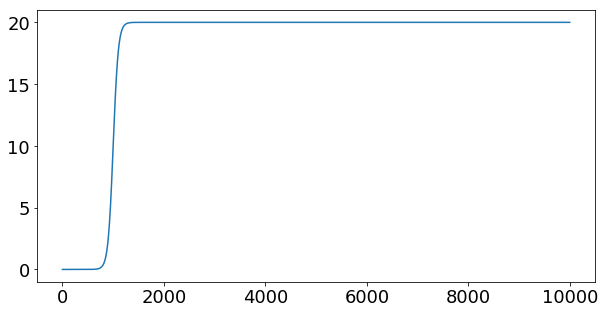

In [22]:
NUM_EPOCH = 10000
plt.figure(figsize=(10,5))
plt.plot([ln.scale_schedule(i, NUM_EPOCH) for i in range(NUM_EPOCH)])
plt.axis*()

In [ ]:
NUM_EPOCH = 5000
learning_rate = lr
for epoch in range(NUM_EPOCH):
    scale = ln.scale_schedule(epoch, NUM_EPOCH)
    #     loss = torch.abs(l1hs(x_tensor, y_tensor, scale=scale))
    (lhs_rt, _), _ = lhs.outer.run(lhs.setup(x_tensor, y_tensor))
    lhs_rt = [lhs_rt[0]-10]*5 + lhs_rt
    rhs_rt, _ = rhs.outer.run_cell(rhs.setup(z_tensor), rhs.outer.initialize_rnn_cell(rhs.setup(z_tensor)))
    formula_cg = ln.And(ln.GreaterThan("lhs", 0), ln.GreaterThan("rhs", 0))
    loss = formula_cg(torch.cat(lhs_rt, 1), torch.cat(rhs_rt, 1))[-1][-1]**2


    loss.backward()
    with torch.no_grad():
        if epoch % 50 == 0:
            print("Epoch number: ", epoch,
                  "\t β is : ", round(β.cpu().data.numpy()[0],3),
                  "\t Gradient is: ", round(β.grad.data.numpy()[0], 3),
                  "\t Loss is: ", round(float(loss.data.numpy()), 3),
                  "\t Scale is: ", round(scale, 3))
            print("Epoch number: ", epoch,
                  "\t α is : ", round(α.cpu().data.numpy()[0],3),
                  "\t Gradient is: ", round(α.grad.data.numpy()[0], 3),
                  "\t Loss is: ", round(float(loss.data.numpy()), 3),
                  "\t Scale is: ", round(scale, 3))
        β -= learning_rate * (β.grad + 0.001*torch.randn(1,  dtype=torch.float64))
        β.grad.zero_()
        α -= learning_rate * (α.grad + 0.001*torch.randn(1,  dtype=torch.float64))
        α.grad.zero_()


# Graphs

In [50]:
import pandas as pd
import torch

In [81]:
def make_bar_graph(data, formula, value_name = "x", method_names = ['1', '2', '3', '4']):
    df_list = []
    for (i,d) in enumerate(data):
        df = pd.DataFrame(OrderedDict({'Formula': formula, value_name: d}))
        df['method'] = str(i)
        df_list.append(df)

    DF = pd.concat(df_list)
    DFG = DF.groupby(['Formula', 'method'])
    DFGSum = DFG.sum().unstack(['method']).sum(axis=1,level=['method'])
    return DF, DFG, DFGSum


def make_comparison_bar_graph(means, stds, formula, kwargs={}):
    DF, DFG, DFGSum = make_bar_graph(means, formula)
    if stds is None:
        ERRGSum = None
    else:       
        ERR, ERRG, ERRGSum = make_bar_graph(stds, formula)
    DFGSum.plot(kind='bar', yerr=ERRGSum, **kwargs)

In [407]:
def IQR(data):
    a,b = np.percentile(data, [25, 75])
    return b - a

def get_mean_time(data, pop=1):
    total_time = data["total_time"]
    num_iters = sum(data["num_iterations"])
    return total_time/num_iters/pop

def get_mean_iterations(data):
    return [np.median(data["num_iterations"]), IQR(data["num_iterations"])]

def get_mean_loss(data):
    if type(data["losses"][0]) == torch.Tensor:
        losses_np = np.array([d.detach().numpy().item() for d in data["losses"]])
        q75, q25 = np.percentile(losses_np, [75 ,25])
        iqr = q75 - q25
        return [np.median(losses_np), iqr]
    q75, q25 = np.percentile(data["losses"], [75 ,25])
    iqr = q75 - q25
    return [np.median(data["losses"]), iqr]

def get_iqr(data):
    if type(data["losses"][0]) == torch.Tensor:
        losses_np = np.array([d.detach().numpy().item() for d in data["losses"]])
        q75, q25 = np.percentile(losses_np, [75 ,25])
        iqr = q75 - q25
        return q75, q25
    q75, q25 = np.percentile(data["losses"], [75 ,25])
    iqr = q75 - q25
    return q75, q25

In [679]:
dcg_1 = np.load("dcg_1_scaling_1.npy").item()
dcg_2 = np.load("dcg_2_scaling_1.npy").item()
dcg_3 = np.load("dcg_3_scaling_1.npy").item()
# dcg_4 = np.load("dcg_4_tuesday.npy").item()
dcg_data = [dcg_1, dcg_2, dcg_3]
dcg_time_mean = [get_mean_time(g) for g in dcg_data]
dcg_time_total = [g["total_time"]/N for g in dcg_data]
dcg_iter_mean = [get_mean_iterations(g)[0] for g in dcg_data]
dcg_iter_std = [get_mean_iterations(g)[1] for g in dcg_data]
dcg_loss_mean = [get_mean_loss(g)[0] for g in dcg_data]
dcg_loss_std = [get_mean_loss(g)[1] for g in dcg_data]
dcg_loss_75 = [get_iqr(g)[0] for g in dcg_data]
dcg_loss_25 = [get_iqr(g)[1] for g in dcg_data]

cg_1 = np.load("cg_1_tuesday.npy").item()
cg_2 = np.load("cg_2_tuesday.npy").item()
cg_3 = np.load("cg_3_tuesday.npy").item()
# cg_4 = np.load("cg_4_tuesday.npy").item()
cg_data = [cg_1, cg_2, cg_3]
cg_time_mean = [get_mean_time(g) for g in cg_data]
cg_time_total = [g["total_time"]/N for g in cg_data]
cg_iter_mean = [get_mean_iterations(g)[0] for g in cg_data]
cg_iter_std = [get_mean_iterations(g)[1] for g in cg_data]
cg_loss_mean = [get_mean_loss(g)[0] for g in cg_data]
cg_loss_std = [get_mean_loss(g)[1] for g in cg_data]
cg_loss_75 = [get_iqr(g)[0] for g in cg_data]
cg_loss_25 = [get_iqr(g)[1] for g in cg_data]


gd_1 = np.load("gd_1.npy").item()
gd_2 = np.load("gd_2.npy").item()
gd_3 = np.load("gd_3.npy").item()
gd_4 = np.load("gd_4.npy").item()
gd_data = [gd_1, gd_2, gd_3]
gd_time_mean = [get_mean_time(g) for g in gd_data]
gd_time_total = [g["total_time"]/N for g in gd_data]
gd_iter_mean = [get_mean_iterations(g)[0] for g in gd_data]
gd_iter_std = [get_mean_iterations(g)[1] for g in gd_data]
gd_loss_mean = [get_mean_loss(g)[0] for g in gd_data]
gd_loss_std = [get_mean_loss(g)[1] for g in gd_data]
gd_loss_75 = [get_iqr(g)[0] for g in gd_data]
gd_loss_25 = [get_iqr(g)[1] for g in gd_data]


ga_1 = np.load("ga_1_20_40.npy").item()
ga_2 = np.load("ga_2_20_40.npy").item()
ga_3 = np.load("ga_3_20_40.npy").item()
ga_4 = np.load("ga_4_20_40.npy").item()
ga_data = [ga_1, ga_2, ga_3]
ga_time_mean = [get_mean_time(g) for g in ga_data]
ga_time_total = [g["total_time"]/N for g in ga_data]
ga_iter_mean = [get_mean_iterations(g)[0] for g in ga_data]
ga_iter_std = [get_mean_iterations(g)[1] for g in ga_data]
ga_loss_mean = [get_mean_loss(g)[0] for g in ga_data]
ga_loss_std = [get_mean_loss(g)[1] for g in ga_data]
ga_loss_75 = [get_iqr(g)[0] for g in ga_data]
ga_loss_25 = [get_iqr(g)[1] for g in ga_data]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x12dc6b128>,
      dtype=object)

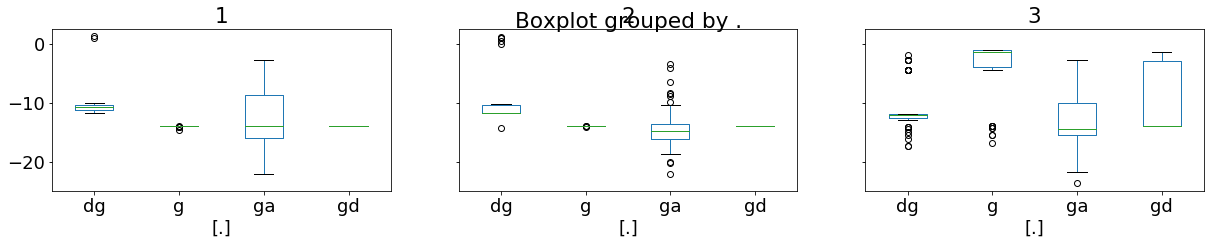

In [671]:
aa = np.concatenate([np.array(dcg_losses, dtype=np.float64).squeeze(1), 
                                      np.array(cg_losses, dtype=np.float64).squeeze(1), 
                                      np.array(gd_losses, dtype=np.float64) , 
                                      np.array(ga_losses, dtype=np.float64)]).T
aa.shape
a = pd.DataFrame(index=range(50), 
                 columns=pd.MultiIndex.from_product(
                         iterables=[['dg', 'g', 'gd', 'ga'], ['1', '2', '3']], 
                         names=['.', 'formula']),
                 data = np.log(aa))
b = a.stack(level=0).reset_index(level=0, drop=True).reset_index()
b.boxplot(by=".", figsize=(20, 3), grid=False, layout=(1, 3), fontsize=18)              

<Figure size 720x720 with 0 Axes>

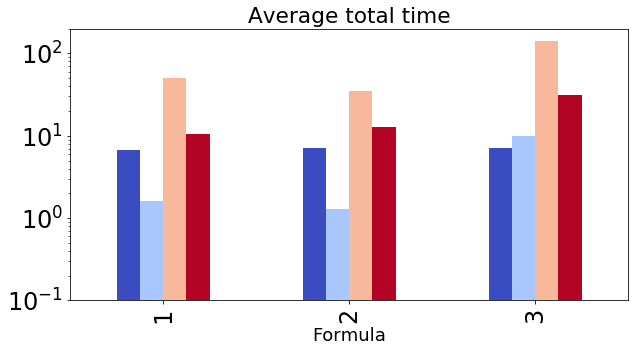

In [680]:
# data = [[1, 2, 3, 4], [5, 6, 7, 8], [2, 3, 4, 5], [5, 4, 7, 3]]
# err = [[1, 2, 3, 4], [.5, .6, .7, .8], [.2, .3, .4, .5], [.5, .4, .7, .3]]
data = [dcg_time_total, cg_time_total, gd_time_total, ga_time_total]
err = [None, None, None, None]
formula = ["1", "2", "3",]
value_name="Total time"
plt.figure(figsize=(10,10))
kwargs = {"colormap": "coolwarm", "figsize": (10,5), "fontsize": 24, "legend": False, "title": "Average total time", "logy": True, "ylim":(0.1, 200)}
make_comparison_bar_graph(data, err, formula, kwargs=kwargs)




<Figure size 720x720 with 0 Axes>

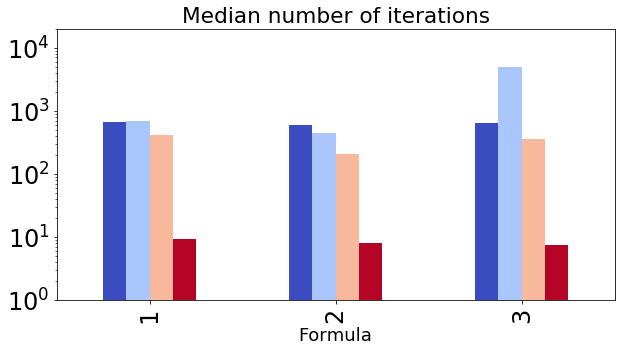

In [681]:
# data = [[1, 2, 3, 4], [5, 6, 7, 8], [2, 3, 4, 5], [5, 4, 7, 3]]
# err = [[1, 2, 3, 4], [.5, .6, .7, .8], [.2, .3, .4, .5], [.5, .4, .7, .3]]
data = [dcg_iter_mean, cg_iter_mean, gd_iter_mean, ga_iter_mean]
err = [dcg_iter_std, cg_iter_std, gd_iter_std, ga_iter_std]
formula = ["1", "2", "3"]
value_name="Average number of Iterations"
plt.figure(figsize=(10,10))
kwargs = {"colormap": "coolwarm", "figsize": (10,5), "fontsize": 24, "legend": False, "logy": True, "title": "Median number of iterations", "ylim":(1, 20000)}
make_comparison_bar_graph(data, n, formula, kwargs=kwargs)


<Figure size 720x720 with 0 Axes>

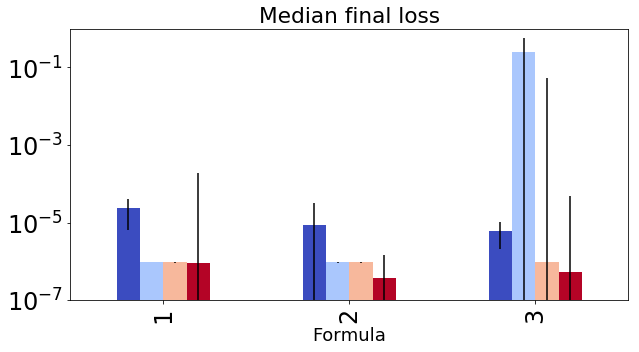

In [683]:
# data = [[1, 2, 3, 4], [5, 6, 7, 8], [2, 3, 4, 5], [5, 4, 7, 3]]
# err = [[1, 2, 3, 4], [.5, .6, .7, .8], [.2, .3, .4, .5], [.5, .4, .7, .3]]
data = [dcg_loss_mean, cg_loss_mean, gd_loss_mean, ga_loss_mean]
err = [dcg_loss_std, cg_loss_std, gd_loss_std, ga_loss_std]
formula = ["1", "2", "3"]
value_name="Number of Iterations"
plt.figure(figsize=(10,10))
kwargs = {"colormap": "coolwarm", "figsize": (10,5), "fontsize": 24, "legend": False, "logy": True, "title": "Median final loss", "ylim":(1E-7, 1)}
make_comparison_bar_graph(data, err, formula, kwargs=kwargs)



<Figure size 720x720 with 0 Axes>

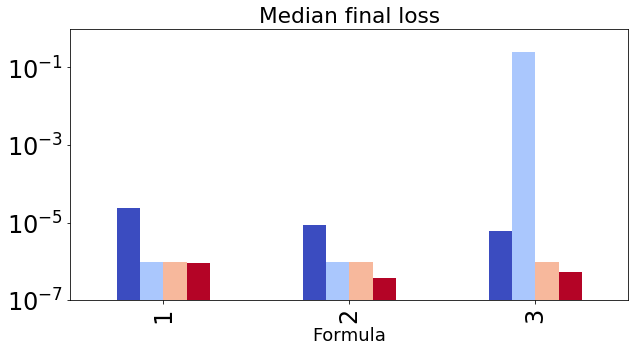

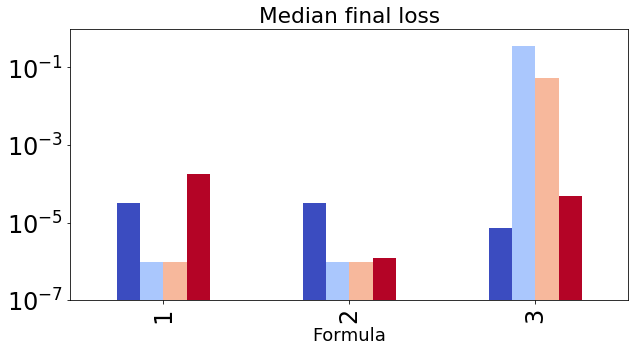

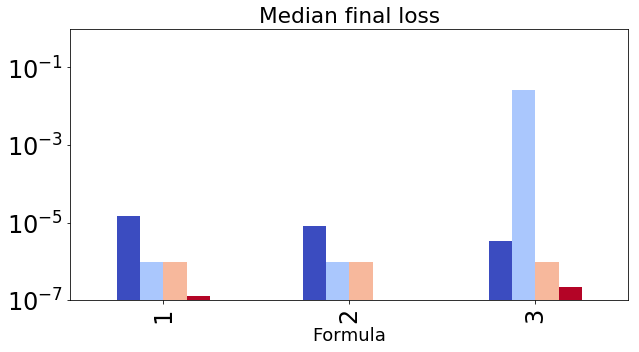

In [686]:
# data = [[1, 2, 3, 4], [5, 6, 7, 8], [2, 3, 4, 5], [5, 4, 7, 3]]
# err = [[1, 2, 3, 4], [.5, .6, .7, .8], [.2, .3, .4, .5], [.5, .4, .7, .3]]
median = [dcg_loss_mean, cg_loss_mean, gd_loss_mean, ga_loss_mean]
q75 = [dcg_loss_75, cg_loss_75, gd_loss_75, ga_loss_75]
q25 = [dcg_loss_25, cg_loss_25, gd_loss_25, ga_loss_25]
n = [None]*4
formula = ["1", "2", "3"]
value_name="Number of Iterations"
plt.figure(figsize=(10,10))
kwargs = {"colormap": "coolwarm", "figsize": (10,5), "fontsize": 24, "legend": False, "logy": True, "title": "Median final loss", "ylim":(1E-7, 1)}
make_comparison_bar_graph(median, n, formula, kwargs=kwargs)
make_comparison_bar_graph(q75, n, formula, kwargs=kwargs)
make_comparison_bar_graph(q25, n, formula, kwargs=kwargs)


